In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr

## Black-Scholes related utilities

In [2]:
def norm_cdf(x):
    """ Approximation of the normal distribution function with an error less than 7.5*10^-8 """
    assert x >= 0 or x < 0
    coefficients = [0.2316419, 0.319381530, -0.356563782, 1.781477937, -1.821255978, 1.33027442]
    if x >= 0:
        t = 1 / (1 + coefficients[0] * x)
        terms = [coefficients[i] * t**i for i in range(1, 6)]
        approx = 1 - (1 / np.sqrt(2 * np.pi)) * np.exp(-x**2 / 2) * sum(terms)
        return approx
    else:
        return 1 - norm_cdf(-x)

In [3]:
def call_eur_bs(r, sig, T, S0, K):
    d = (np.log(S0 / K) + r * T + 0.5 * sig**2 * T) / (sig * np.sqrt(T))
    return (
        S0 * np.exp(r * T) * norm_cdf(sig * np.sqrt(T) - d)
        - K * norm_cdf(-d)
    )

In [4]:
def price_paths_bs(r, sig, T, S0, num_paths, num_subdivs):
    step = (T/num_subdivs)
    log_diffs = (r-0.5*sig**2) * step + sig*np.sqrt(step)*npr.normal(0, 1, size=(num_paths, num_subdivs))
    log_diffs = np.concatenate((np.log(S0)*np.ones((num_paths, 1)), log_diffs), axis=1)
    log_paths = np.cumsum(log_diffs, axis=1)
    price_paths = np.exp(log_paths)

    return price_paths

## Turnbull & Wakeman approximation

Turnbull & Wakeman have provided an approximation of the price of an asian option, as a european option with different parameters.

In [5]:
def tnw_coeffs_con(r, sig, T):
    """ Calculates the r_a and sigma_a coefficients from the Turnbull & Wakeman approximation for an asian option """
    M1 = (np.exp(r*T)-1)/(r*T)
    M2 = ( 
        (2*np.exp((2*r+sig**2)*T)) / ((r+sig**2) * (2*r+sig**2) * T**2)
        + (2/(r*T**2)) * (1/(2*r+sig**2) - np.exp(r*T) / (r+sig**2))
    )

    r_a = np.log(M1) / T 
    sig_a = np.sqrt(-2*r_a + np.log(M2)/T)
    return (r_a, sig_a)

In [6]:
def tnw_coeffs_dis(r, sig, T, num_subdivs):
    """ Calculates the r_a and sigma_a coefficients from the Turnbull & Wakeman approximation for an asian option """
    dt = T/num_subdivs
    N = num_subdivs
    t0 = np.exp((2*r+sig**2)*dt)
    t1 = np.exp(r*dt)
    M1 = (1 / N)*( (t1*(1-np.exp(r*T))) / (1-t1) )
    M2 = (
        (1/(N**2))*( (t0 * (1-np.exp((2*r+sig**2)*T)) ) / (1-t0) )
        + (1/(N**2))*(2*t1/(1-t1))*( 
        t0 * ( (1-np.exp((2*r+sig**2)*(N-1)*dt)) / (1-t0) )
        - np.exp(((N+1)*r+sig**2)*dt) * ( (1-np.exp((r+sig**2)*(N-1)*dt)) / (1-np.exp((r+sig**2)*dt)) )
    ))

    r_A = np.log(M1) / T
    sig_a = np.sqrt(np.log(M2)/T - 2 * r_A)

    return (r_A, sig_a)

In [7]:
def call_asian_bs_tnw(r, sig, T, S0, K, num_subdivs):
    """ Calculates price of an asian option under the Turnbull & Wakeman approximation and the Black-Scholes model """
    r_a, sig_a = tnw_coeffs_dis(r, sig, T, num_subdivs)
    return np.exp(-r*T) * call_eur_bs(r_a, sig_a, T, K, S0)

## Monte-Carlo approximation

In [8]:
def call_asian_bs_mc(r, sig, T, S0, K, num_paths, num_subdivs):
    price_paths = price_paths_bs(r, sig, T, S0, num_paths, num_subdivs)

    payoffs_asian = np.exp(-r*T)*np.maximum(price_paths.mean(axis=1) - K, 0)
    var = payoffs_asian.var(ddof=1) / num_paths

    return payoffs_asian.mean(), var

In [9]:
def ctrl_coeffs(r, sig, n):
    sig_e = (sig/n)*np.sqrt( ((n+1)*(2*n+1)) / 6 )
    r_e = 0.5*sig_e**2 + (r-0.5*sig**2)*(n+1)/(2*n)

    return (r_e, sig_e)

In [10]:
def call_asian_bs_mc_ctrl(r, sig, T, S0, K, num_paths, num_subdivs):
    """ Calculate a monte-carlo simulation of the asian price with a lower variance """

    price_paths = price_paths_bs(r, sig, T, S0, num_paths, num_subdivs)
    payoffs_asian = np.maximum(price_paths.mean(axis=1) - K, 0)
    control_samples = np.maximum(np.exp( np.log(price_paths)[:,1:].mean(axis=1) ) - K, 0)

    r_e, sig_e = ctrl_coeffs(r, sig, num_subdivs)
    control_mean = call_eur_bs(r_e, sig_e, T, S0, K)
    res_sample = np.exp(-r*T)*(payoffs_asian - control_samples + control_mean)

    var = res_sample.var(ddof=1) / num_paths
    return (res_sample.mean(), var)
    

## Tests

In [17]:
# Spot
S0 = 100
# Strike
K = 100
# Vol.
sig = 0.3
# Expiration
T = 6
# Risk-free rate
r = 0.02
# Number of simulations (monte-carlo)
N = 7000
# Path subdivisions
n = 20

In [12]:
tnw_approx = call_asian_bs_tnw(r, sig, T, S0, K, num_subdivs=n)
mc_approx, var = call_asian_bs_mc(r, sig, T, S0, K, num_paths=N, num_subdivs=n)
mc_approx_c, var_c = call_asian_bs_mc_ctrl(r, sig, T, S0, K, num_paths=N, num_subdivs=n)

print(f"Approximation Monte-Carlo  : {mc_approx:.3f}€ (var={var:.6f})")
print(f"Variable de contrôle       : {mc_approx_c:.3f}€ (var={var_c:.6f})")
print(f"Approximation T&W discrète : {tnw_approx:.3f}€")

Approximation Monte-Carlo  : 18.609€ (var=0.240275)
Variable de contrôle       : 18.208€ (var=0.004911)
Approximation T&W discrète : 18.948€


## Graphes

In [13]:
def var_evolution(arr):
	output_arr = np.zeros(len(arr)-2)
	for i in range(len(output_arr)):
		output_arr[i] = arr[:i+2].var(ddof=1) / (i+1)
	return output_arr

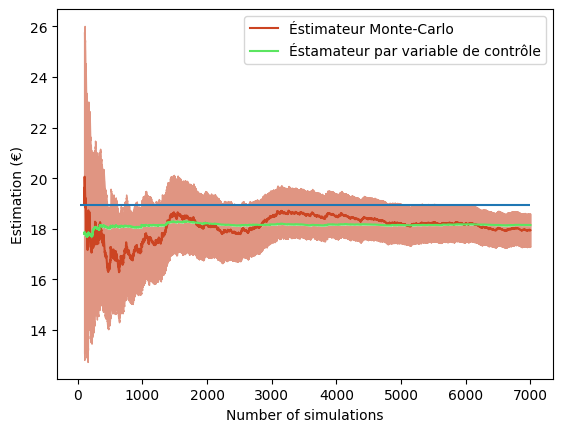

In [ ]:
num_paths = N     # Size of Monte-Carlo simulation
num_subdivs = n   # Number of steps for brownian motion
num_samples = 100 # Number of sample for the graphs

start_index = 100 # Starting plot index
GREEN = "#5be560" 
RED = "#cc4422"
FILL_RED = "#e09582"
FILL_GREEN = "#b0e8b2"

# Calculation of the paths
price_paths = price_paths_bs(r, sig, T, S0, num_paths, num_subdivs)

# Control variable monte-carlo
r_e, sig_e = ctrl_coeffs(r, sig, num_subdivs)
control_mean = call_eur_bs(r_e, sig_e, T, S0, K)
asian_mc_samples = np.maximum(price_paths.mean(axis=1) - K, 0)
control_samples = np.maximum(np.exp( np.log(price_paths)[:,1:].mean(axis=1) ) - K, 0)
asian_ctrl_mc_samples = np.exp(-r*T)*(asian_mc_samples - control_samples + control_mean)
asian_mc_samples *= np.exp(-r*T)

# TWN approx
tnw_approx = call_asian_bs_tnw(r, sig, T, S0, K, num_subdivs=n)

# Evolution of the Monte-Carlo simulation
mean_vec = np.array([(1/i) for i in range(1, len(asian_mc_samples)+1)])
asian_mc_evol = asian_mc_samples.cumsum() * mean_vec
asian_mc_ctrl_evol = asian_ctrl_mc_samples.cumsum() * mean_vec

# Calculation of the variance
asian_mc_std = np.sqrt(var_evolution(asian_mc_samples))
asian_mc_lower_bound = asian_mc_evol[2:] -1.61*asian_mc_std
asian_mc_upper_bound = asian_mc_evol[2:] +1.61*asian_mc_std

asian_mc_ctrl_std = np.sqrt(var_evolution(asian_mc_ctrl_evol))
asian_mc_ctrl_lower_bound = asian_mc_ctrl_evol[2:] -1.61*asian_mc_ctrl_std
asian_mc_ctrl_upper_bound = asian_mc_ctrl_evol[2:] +1.61*asian_mc_ctrl_std

# Ploting
x = np.arange(start=start_index, stop=len(asian_mc_ctrl_evol), step=1)

plt.plot(x, asian_mc_evol[start_index:], c=RED, label="Éstimateur Monte-Carlo")
plt.fill_between(x, asian_mc_lower_bound[start_index-2:], asian_mc_upper_bound[start_index-2:], color=FILL_RED)

plt.plot(x, asian_mc_ctrl_evol[start_index:], c=GREEN, label="Éstimateur par variable de contrôle")
plt.fill_between(x, asian_mc_ctrl_lower_bound[start_index-2:], asian_mc_ctrl_upper_bound[start_index-2:], color=FILL_GREEN)

plt.hlines(tnw_approx, xmin=30, xmax=N)
plt.xlabel("Number of simulations")
plt.ylabel("Estimation (€)")
plt.legend()
plt.savefig("out.png", dpi=300)
plt.show()